TUGAS 5

Dewanti Sholihat Geavonny 18316030

In [ ]:
#Menghubugkan google colab ke google drive
from google.colab import drive
drive.mount('/content/gdrive')
from google.colab.patches import cv2_imshow

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [ ]:
#Import library
import cv2
import numpy as np
from keras.datasets import mnist
from sklearn.svm import LinearSVC
from sklearn.externals import joblib
from keras.models import Sequential
from keras.layers.convolutional import Conv2D
from keras.layers.convolutional import MaxPooling2D
from skimage.feature import hog
from keras.layers import Dense
from keras.layers import Flatten
from keras.layers import Dropout
from keras.utils import np_utils
from keras.callbacks import ModelCheckpoint
from keras import backend as K
import os
from tensorflow.python.keras import backend as K
from keras import backend as K
import tensorflow.compat.v1 as tf
tf.disable_v2_behavior()
K.tensorflow_backend.set_image_dim_ordering('th')

In [ ]:
from keras.preprocessing.image import ImageDataGenerator

#Augmentation
#Augmentasi yang dilakukan pada data test dan data training adalah sama
#Dilakukan beberapa transformasi, yaitu rescale, rotasi, zoom, shift, shear, dan flip untuk proses augmentasi
#Train dan test data menggunakan data yang terdapat di folder drive, dengan ukuran gambar 28x28 piksel
#warna dari data gambar test dan train berupa greyscale

aug = ImageDataGenerator(rescale=1./255,horizontal_flip=True,height_shift_range=0.2,width_shift_range=0.2,shear_range=0.15, rotation_range=20,zoom_range=0.15)

# Load data training
train_generator = aug.flow_from_directory(
        r"gdrive/My Drive/Dataset Handwriting/Train",
        target_size=(28, 28),
        batch_size=100,
        class_mode='categorical',
        color_mode='grayscale')

# Load data test
test_generator = aug.flow_from_directory(
        r"gdrive/My Drive/Dataset Handwriting/Test",
        target_size=(28, 28),
        batch_size=100,
        class_mode='categorical',
        color_mode='grayscale')

Found 3328 images belonging to 10 classes.
Found 1110 images belonging to 10 classes.


In [ ]:
if K.image_data_format() == 'channels_first':
    input_shape = (1, 28, 28)
else:
    input_shape = (28, 28, 1)

# Create model
model = Sequential()
model.add(Conv2D(32, (5, 5), input_shape=input_shape, activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.5))
model.add(Flatten())
model.add(Dense(128, activation='relu'))
model.add(Dense(10, activation='softmax'))

# Compile model
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

# Checkpoint
filepath="gdrive/My Drive/bobot/best_weights.hdf5" #setiap bobot akurasi tertinggi yang diperoleh disimpan pada folder bobot pada gdrive
checkpoint = ModelCheckpoint(filepath, monitor='acc', verbose=1, save_best_only=True, mode='max')
callbacks_list = [checkpoint]

model.fit_generator(
        train_generator,
        steps_per_epoch=6000 // 100,
        validation_data=test_generator,
        validation_steps=3000 // 100,
        epochs=100,
        callbacks=callbacks_list, verbose=0)


Epoch 00001: acc improved from -inf to 0.10881, saving model to gdrive/My Drive/bobot/best_weights.hdf5

Epoch 00002: acc improved from 0.10881 to 0.14071, saving model to gdrive/My Drive/bobot/best_weights.hdf5

Epoch 00003: acc improved from 0.14071 to 0.16530, saving model to gdrive/My Drive/bobot/best_weights.hdf5

Epoch 00004: acc improved from 0.16530 to 0.18818, saving model to gdrive/My Drive/bobot/best_weights.hdf5

Epoch 00005: acc improved from 0.18818 to 0.20833, saving model to gdrive/My Drive/bobot/best_weights.hdf5

Epoch 00006: acc improved from 0.20833 to 0.23012, saving model to gdrive/My Drive/bobot/best_weights.hdf5

Epoch 00007: acc improved from 0.23012 to 0.25894, saving model to gdrive/My Drive/bobot/best_weights.hdf5

Epoch 00008: acc improved from 0.25894 to 0.28683, saving model to gdrive/My Drive/bobot/best_weights.hdf5

Epoch 00009: acc improved from 0.28683 to 0.29184, saving model to gdrive/My Drive/bobot/best_weights.hdf5

Epoch 00010: acc improved from

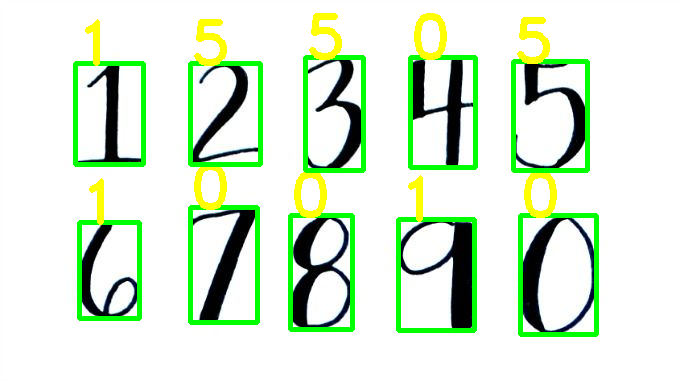

-1

In [ ]:
if K.image_data_format() == 'channels_first':
    input_shape = (1, 28, 28)
else:
    input_shape = (28, 28, 1)

# create model
model = Sequential()
model.add(Conv2D(32, (5, 5), input_shape=input_shape, activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.2))
model.add(Flatten())
model.add(Dense(128, activation='relu'))
model.add(Dense(10, activation='softmax'))

# load weights
# bobot tertinggi akurasi di load kembali dari filepath nya
model.load_weights("gdrive/My Drive/bobot/best_weights.hdf5")

# Compile model
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

# Read the input image
im = cv2.imread(r"gdrive/My Drive/tes_angka.jpg")

# Convert to grayscale and apply Gaussian filtering
im_gray = cv2.cvtColor(im, cv2.COLOR_BGR2GRAY)
im_gray = cv2.GaussianBlur(im_gray, (5, 5), 0)

# Threshold the image
ret, im_th = cv2.threshold(im_gray, 90, 255, cv2.THRESH_BINARY_INV)

# Find contours in the image
ctrs, hier = cv2.findContours(im_th.copy(), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

# Get rectangles contains each contour
rects = [cv2.boundingRect(ctr) for ctr in ctrs]

# For each rectangular region, calculate HOG features and predict
# the digit using Linear SVM.
for rect in rects:
    # Draw the rectangles
    cv2.rectangle(im, (rect[0], rect[1]), (rect[0] + rect[2], rect[1] + rect[3]), (0, 255, 0), 3)
    # Make the rectangular region around the digit
    leng = int(rect[3] * 1.6)
    pt1 = int(rect[1] + rect[3] // 2 - leng // 2)
    pt2 = int(rect[0] + rect[2] // 2 - leng // 2)
    roi = im_th[pt1:pt1+leng, pt2:pt2+leng]
    # Resize the image
    roi = cv2.resize(roi, (28, 28), interpolation=cv2.INTER_AREA)
    roi = roi.reshape(1, 28, 28)
    nbr = model.predict(np.array([roi], 'float64'))
    nbr = np.argmax(nbr)
    cv2.putText(im, str(int(nbr)), (rect[0], rect[1]),cv2.FONT_HERSHEY_DUPLEX, 2, (0, 255, 255), 3)
cv2_imshow(im)
cv2.waitKey()